Train one XGBoost model to predict streamflow for all stations. Forcings are aggregated from hourly to daily to match streamflow resolution. RandomSearchCV to find good parameters.

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../..')
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn import metrics
from datetime import datetime, timedelta
import hydroeval
import netCDF4 as nc
import xgboost as xgb
import scipy as sp
from src import load_data, evaluate

np.random.seed(0)

time_stamp = datetime.now().strftime('%Y%m%d-%H%M%S')
time_stamp

'20190708-203652'

In [2]:
station_data_dict = load_data.load_train_test_gridded_aggregatedForcings(include_all_forcing_vars=False)

In [3]:
param_dist = {
    'max_depth': sp.stats.randint(1, 8),
    'learning_rate': sp.stats.uniform(0.0005, 0.5),
    'gamma': sp.stats.uniform(0, 1),
    'min_child_weight': sp.stats.randint(1, 15),
    'subsample': sp.stats.uniform(0.7, 0.3),
    'colsample_bytree': sp.stats.uniform(0.4, 0.6),
    'colsample_bylevel': sp.stats.uniform(0.4, 0.6),
    'reg_alpha': sp.stats.expon(0, 20),
    'reg_lambda': sp.stats.expon(0, 20),
}

In [4]:
# Create test and train splits for each station (by time), then create predictions for each subbasin
history = 7
train_start = datetime.strptime('2010-01-01', '%Y-%m-%d') + timedelta(days=history + 1)
train_end = '2012-12-31'
test_start = datetime.strptime(train_end, '%Y-%m-%d') + timedelta(days=1)
test_end = '2014-12-31'

validation_fraction = 0.1

data = pd.DataFrame()
data = pd.concat([station_data_dict[station].reset_index() for station in station_data_dict.keys()], ignore_index=True)

data = data.join(pd.get_dummies(data['station'], prefix='station'))
print(data.shape)

train = data[(data['date'] >= train_start) & (data['date'] <= train_end)].copy()
num_validation_samples = int(validation_fraction * train.shape[0])
shuffle_indices = np.arange(train.shape[0])
np.random.shuffle(shuffle_indices)
train = train.iloc[shuffle_indices]
val, train = train.iloc[:num_validation_samples].copy(), train.iloc[num_validation_samples:].copy()

test = data[(data['date'] >= test_start) & (data['date'] <= test_end)].copy()
print('Shapes: train {}, val {}, test {}'.format(train.shape, val.shape, test.shape))

val = [(train.drop(['station', 'date', 'runoff'], axis=1), train['runoff']), 
       (val.drop(['station', 'date', 'runoff'], axis=1), val['runoff'])]

xgb_model = xgb.XGBRegressor(n_estimators=1000, n_jobs=-1, random_state=123)
m = model_selection.RandomizedSearchCV(xgb_model, param_dist, n_iter=1000, cv=3, return_train_score=True, scoring='neg_mean_squared_error', n_jobs=-1, random_state=123, verbose=5)
m.fit(train.drop(['station', 'date', 'runoff'], axis=1), train['runoff'], eval_set=val, eval_metric='rmse', early_stopping_rounds=100, verbose=False)

cv_results = pd.DataFrame(m.cv_results_).sort_values(by='mean_test_score', ascending=False)
print(cv_results.filter(regex='param_|mean_test_score|mean_train_score', axis=1).head())
print('Best params: {}'.format(m.best_params_))
print(cv_results.loc[m.best_index_, ['mean_train_score', 'mean_test_score']])

test = test[~pd.isna(test['runoff'])]

predict = test.copy()
predict['actual'] = predict['runoff']
predict['runoff'] = np.nan
predict['runoff'] = m.predict(predict.drop(['station', 'actual', 'date', 'runoff'], axis=1))

/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


(82918, 8773)
Shapes: train (44081, 8773), val (4897, 8773), test (33580, 8773)
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 37.3min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed: 88.1min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed: 145.1min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed: 214.3min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed: 290.3min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed: 390.5min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed: 479.0min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed: 581.5min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 700.5min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 866.9min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboo

    param_colsample_bylevel param_colsample_bytree param_gamma  \
232                0.835762               0.727974    0.695974   
38                 0.776969               0.980507    0.281418   
779                0.861702               0.734111    0.660662   
999                0.917596               0.575961    0.382414   
747                 0.99811               0.615706   0.0379134   

    param_learning_rate param_max_depth param_min_child_weight  \
232            0.145673               3                      5   
38             0.123698               6                      8   
779             0.10838               6                     11   
999            0.138932               4                      6   
747           0.0860007               6                     12   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
232         45.1919          8.02157        0.970885     -1040.337117   
38          44.5265         0.703116        0.847443     -10

02GA010 	NSE: 0.3304991696706596 	MSE: 319.20028644512695 (clipped to 0)
02GA018 	NSE: 0.2561010705804697 	MSE: 186.83258209577602 (clipped to 0)
02GA038 	NSE: 0.17077943809415286 	MSE: 136.43867170974758 (clipped to 0)
02GA047 	NSE: 0.0688424784020395 	MSE: 72.99346108474474 (clipped to 0)
02GB001 	NSE: 0.31425153196744593 	MSE: 5149.885412557333 (clipped to 0)
02GB007 	NSE: 0.2262948778417977 	MSE: 24.1953178210781 (clipped to 0)
02GC002 	NSE: 0.4327650282765848 	MSE: 72.89141520932853 (clipped to 0)
02GC007 	NSE: 0.27137229294649867 	MSE: 21.9472461573216 (clipped to 0)
02GC010 	NSE: 0.2794159149111254 	MSE: 42.838666066874254 (clipped to 0)
02GC018 	NSE: 0.4772497872601664 	MSE: 35.40420000946315 (clipped to 0)
02GC026 	NSE: 0.450898581199061 	MSE: 88.31349304953407 (clipped to 0)
02GD004 	NSE: 0.16556236203385777 	MSE: 45.94670091787509 (clipped to 0)
02GE007 	NSE: 0.09499580197054924 	MSE: 32.73857978802468 (clipped to 0)
02GG002 	NSE: 0.5599721416590422 	MSE: 106.12716258155407 

../src/evaluate.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:41: Ru

04164000 	NSE: 0.4681849926691396 	MSE: 93.18853849399419 (clipped to 0)
04165500 	NSE: 0.5183410610528515 	MSE: 215.61891944127066 (clipped to 0)
04166100 	NSE: -0.4463288762366442 	MSE: 10.606374664766937 (clipped to 0)
04166500 	NSE: 0.27546111187428746 	MSE: 25.043173953686686 (clipped to 0)
04174500 	NSE: 0.2765862743542429 	MSE: 68.41630083863838 (clipped to 0)
04176500 	NSE: 0.2095305618135721 	MSE: 539.9492920561231 (clipped to 0)


../src/evaluate.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:41: Ru

04177000 	NSE: 0.2651702478883381 	MSE: 19.803536759503288 (clipped to 0)
04193500 	NSE: 0.5945473678567483 	MSE: 28706.350148358924 (clipped to 0)
04195820 	NSE: 0.6199583074648423 	MSE: 446.0907858632918 (clipped to 0)
04196800 	NSE: 0.44416795075365334 	MSE: 166.33189975086557 (clipped to 0)
04197100 	NSE: 0.49218661598111957 	MSE: 52.08357999167006 (clipped to 0)
04198000 	NSE: 0.6395188734543364 	MSE: 2663.0757356324334 (clipped to 0)


../src/evaluate.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:41: Ru

04199000 	NSE: 0.540058738464988 	MSE: 470.3374517533633 (clipped to 0)
04199500 	NSE: 0.5276870287059474 	MSE: 191.12055681154402 (clipped to 0)
04200500 	NSE: 0.5356108227264138 	MSE: 464.7165511675916 (clipped to 0)
04207200 	NSE: 0.11405787362838415 	MSE: 20.736619480126475 (clipped to 0)
04208504 	NSE: 0.5860499288503169 	MSE: 404.2341067025851 (clipped to 0)
04209000 	NSE: 0.5140894055435185 	MSE: 151.92287059446141 (clipped to 0)


../src/evaluate.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:41: Ru

04212100 	NSE: 0.5822760648133298 	MSE: 613.3545127245408 (clipped to 0)
04213000 	NSE: 0.41169576425095666 	MSE: 105.58251195084087 (clipped to 0)
04213500 	NSE: 0.5379180650945226 	MSE: 473.36451715570234 (clipped to 0)
04214500 	NSE: 0.3409928120201089 	MSE: 79.4348067874134 (clipped to 0)
04215000 	NSE: 0.24521491270536722 	MSE: 72.49923070909638 (clipped to 0)
04215500 	NSE: 0.4217421766310223 	MSE: 104.42463788430275 (clipped to 0)
Median NSE (clipped to 0) 0.4166909807609099 / Min -0.4463288762366442 / Max 0.6395188734543364
Median MSE (clipped to 0) 91.57361611874347 / Min 10.606374664766937 / Max 28706.350148358924


../src/evaluate.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))


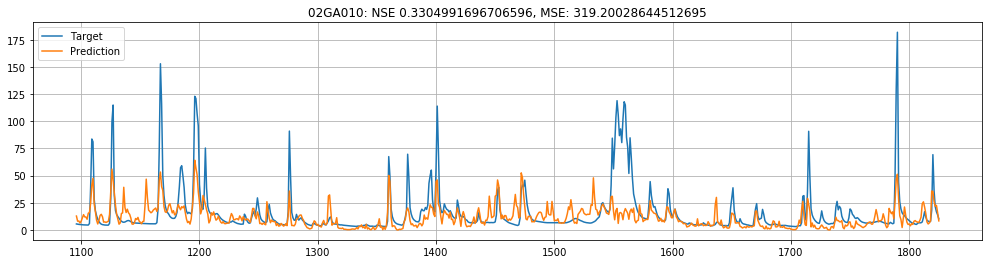

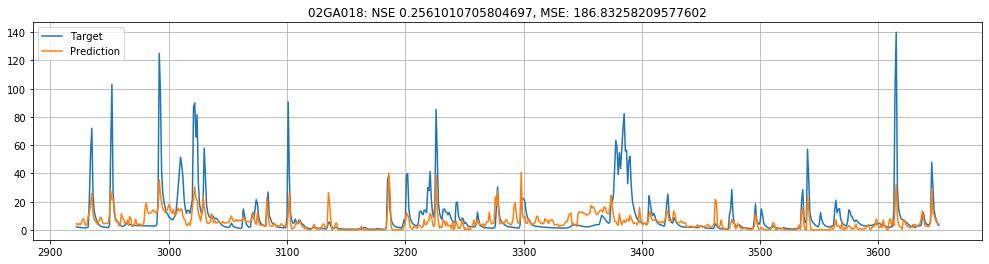

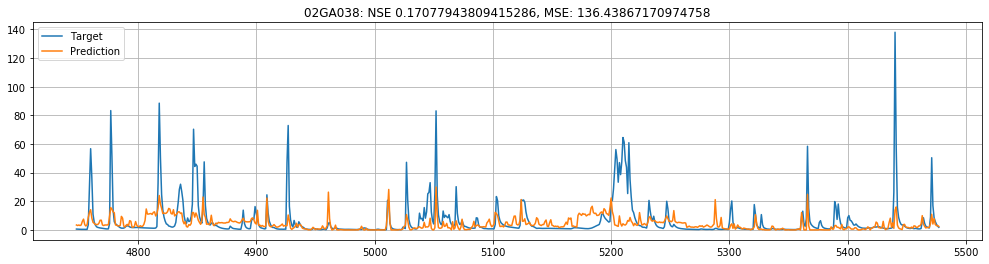

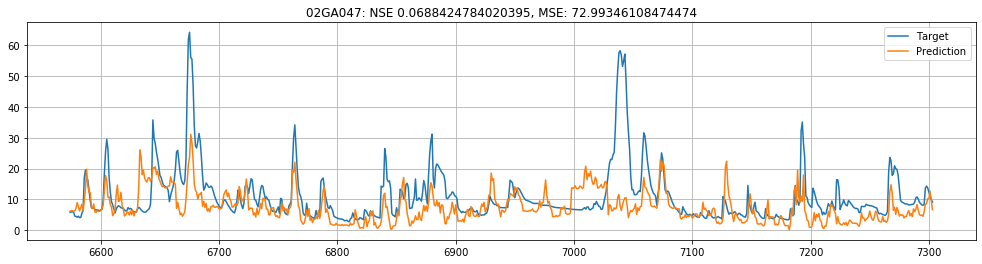

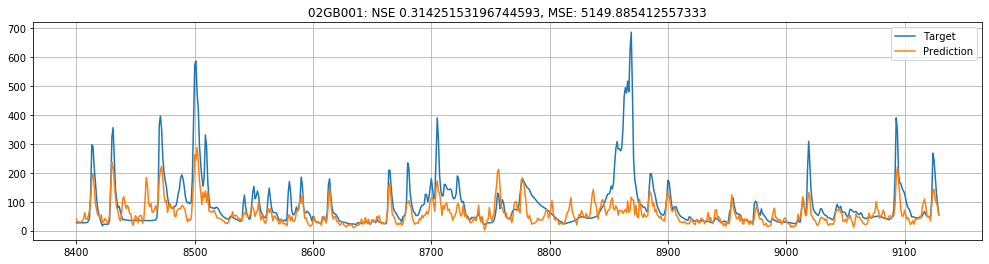

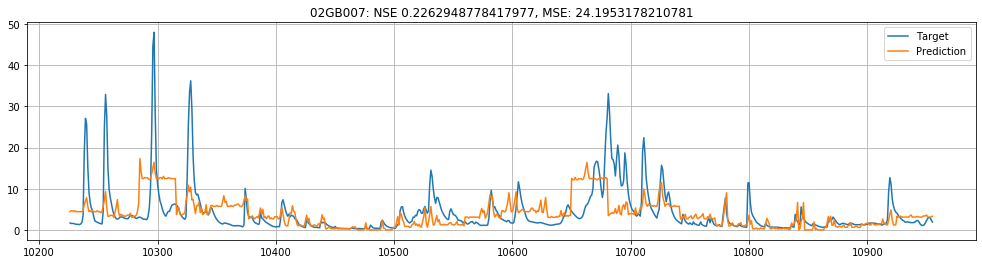

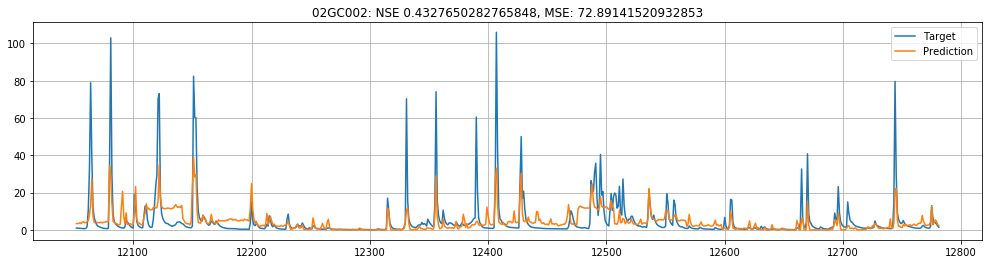

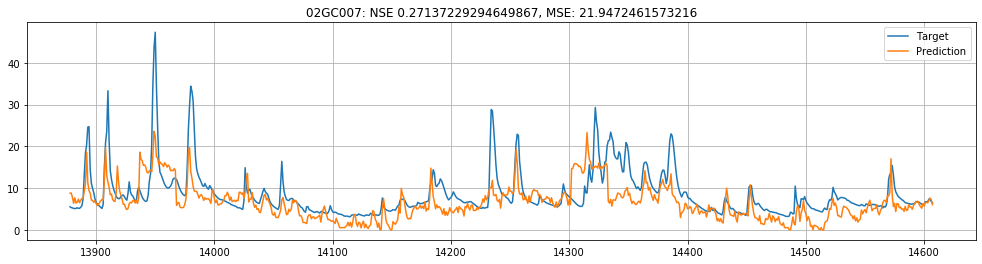

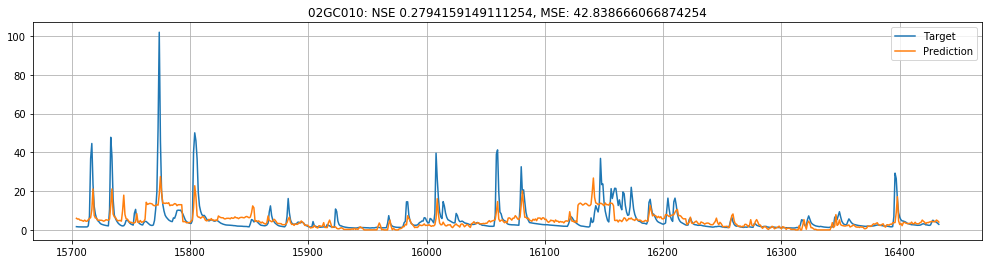

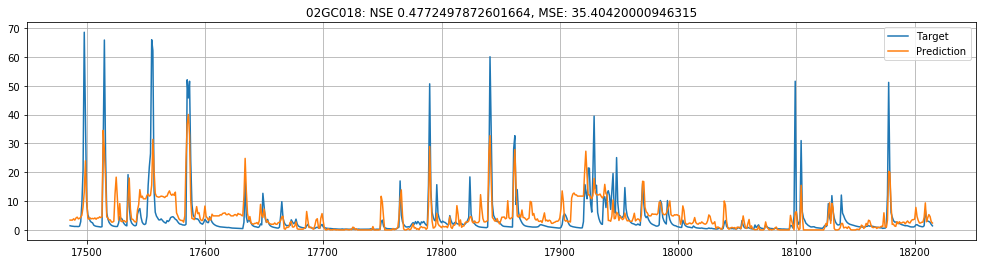

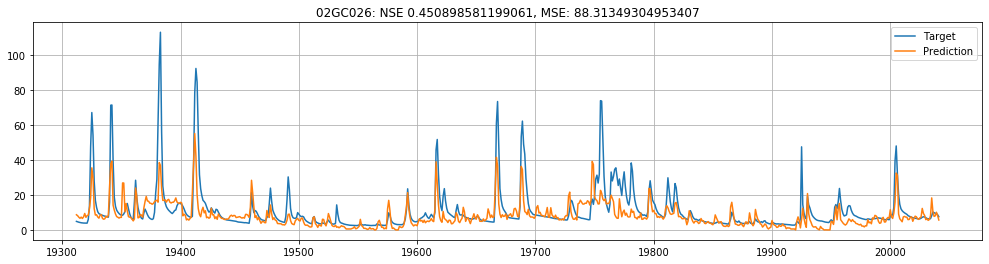

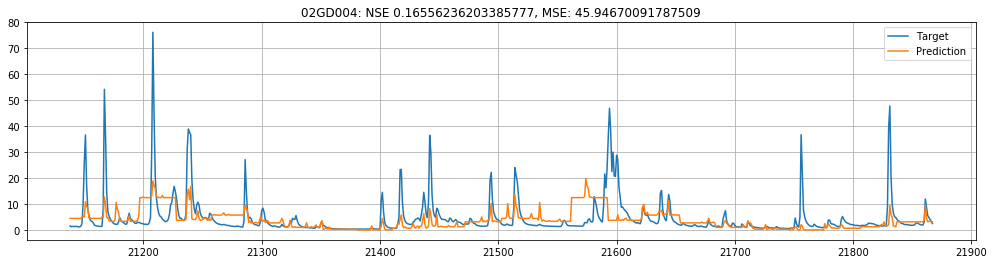

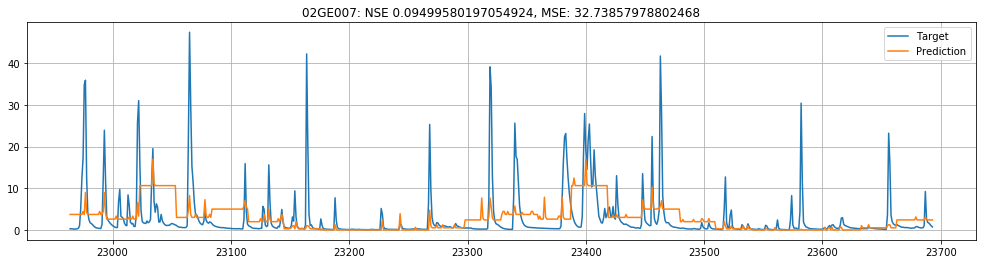

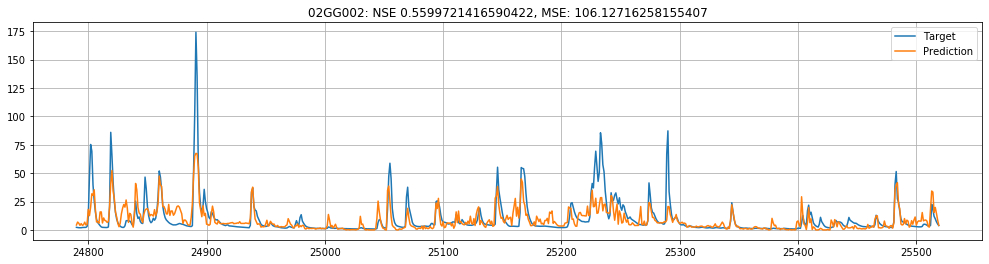

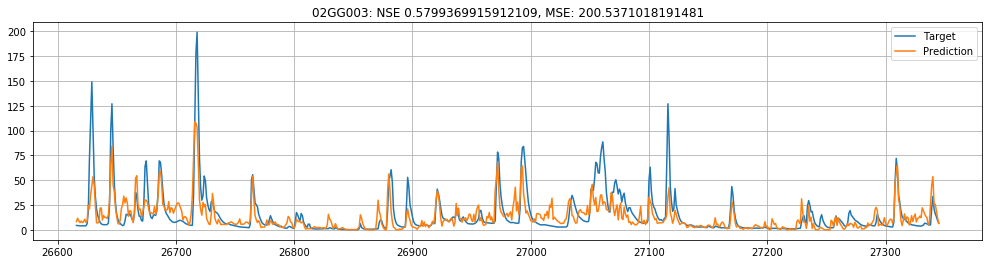

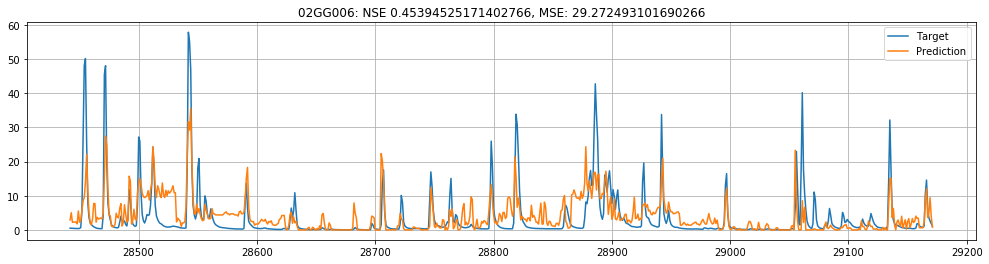

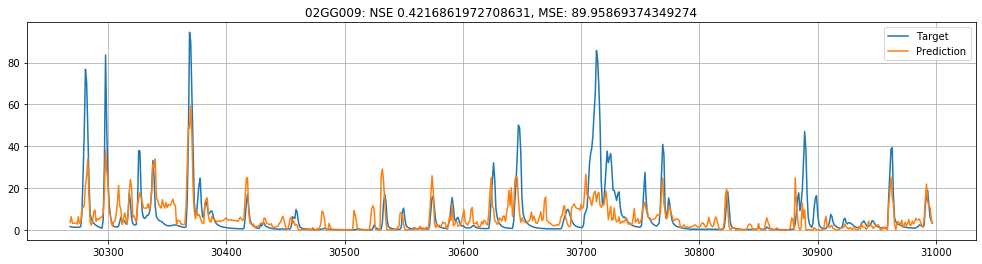

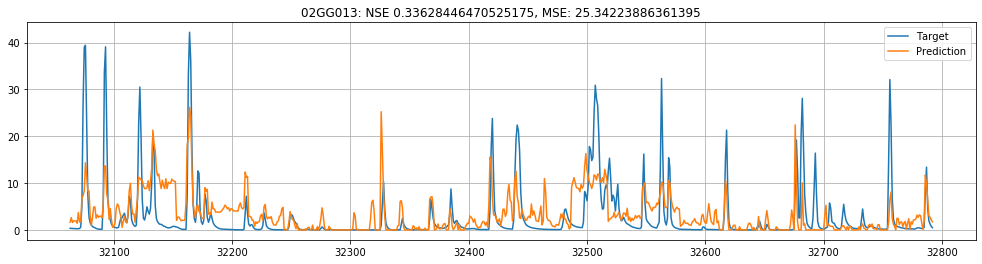

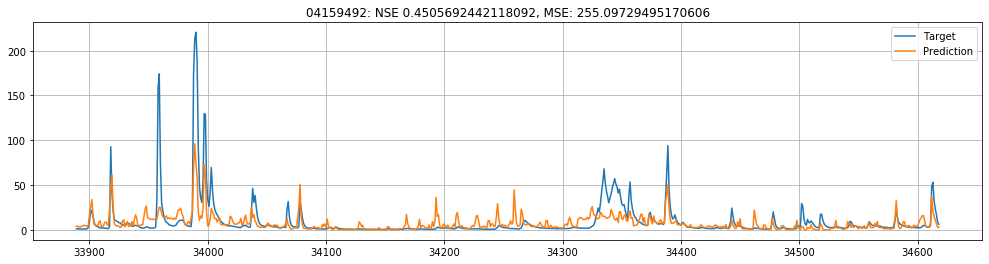

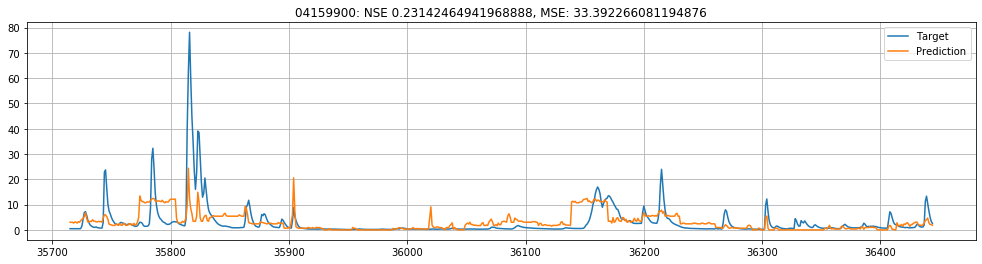

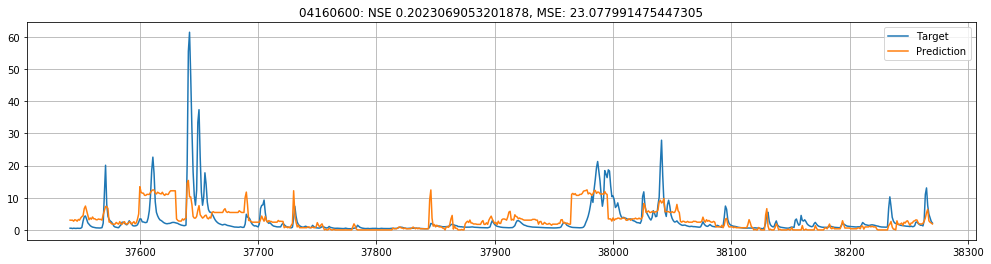

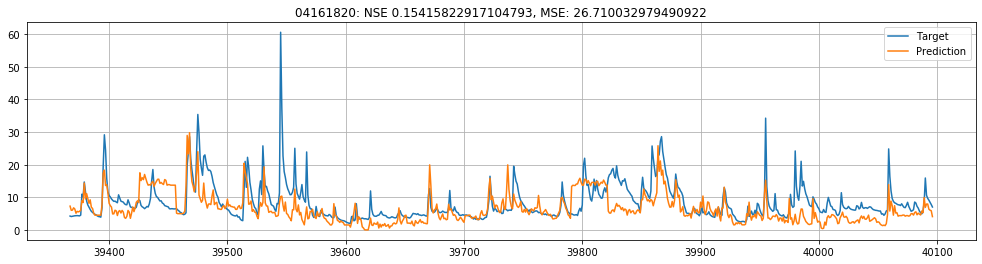

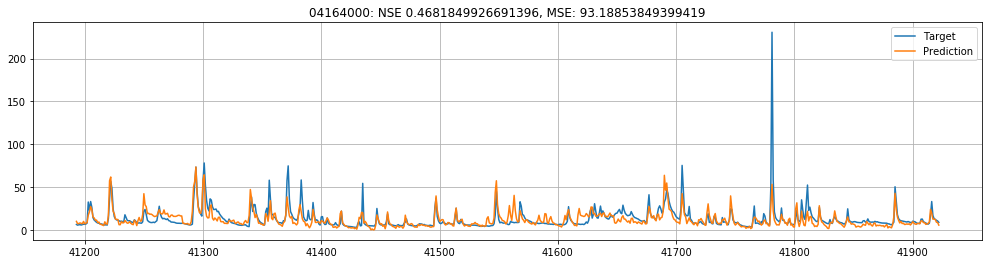

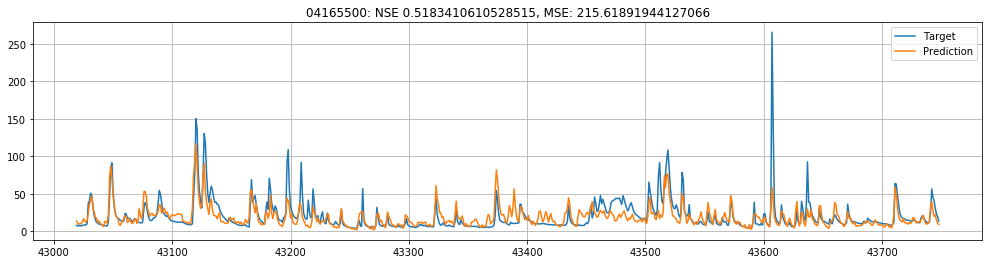

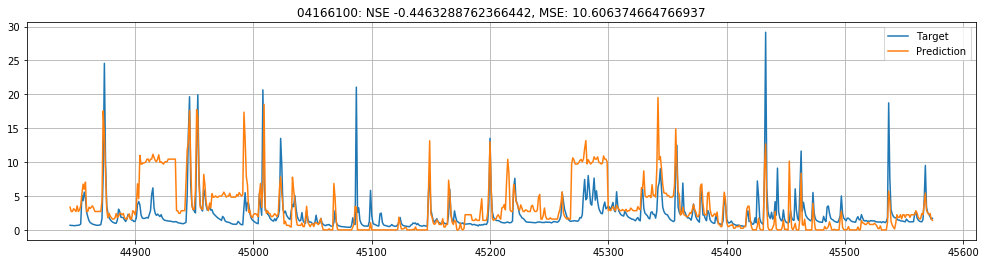

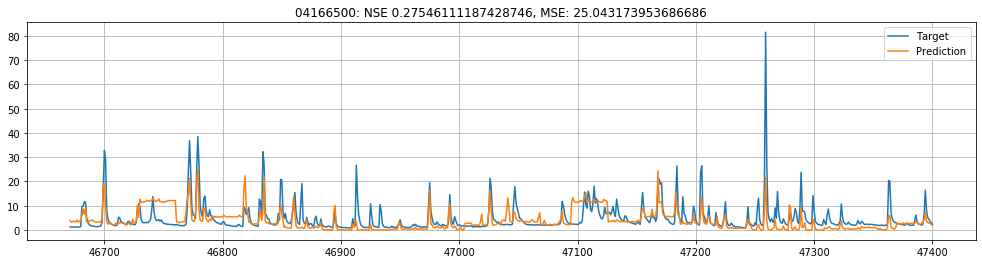

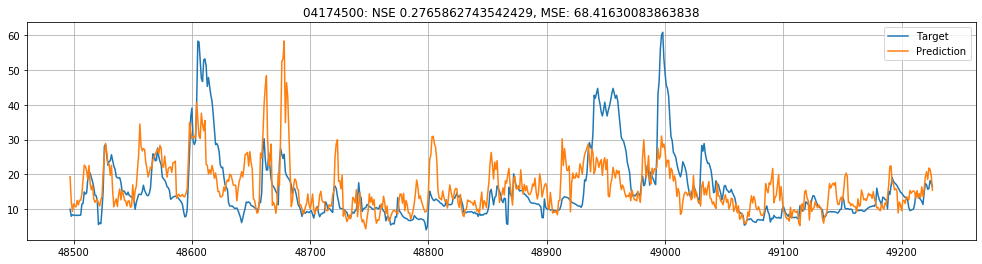

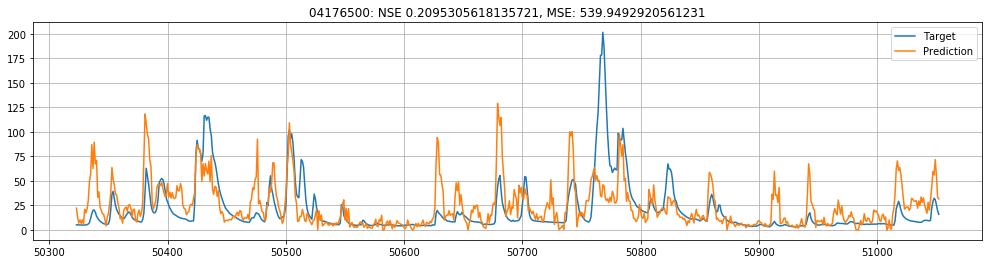

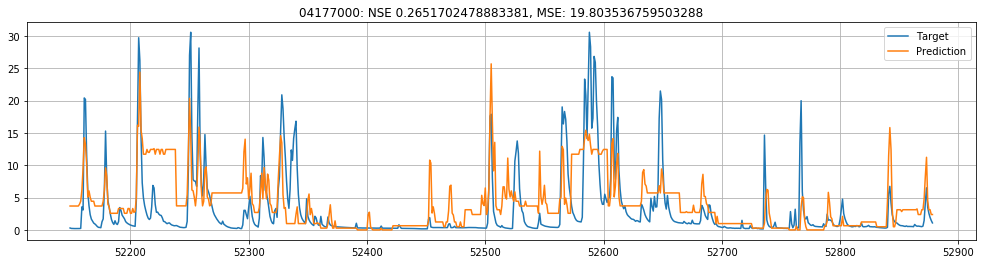

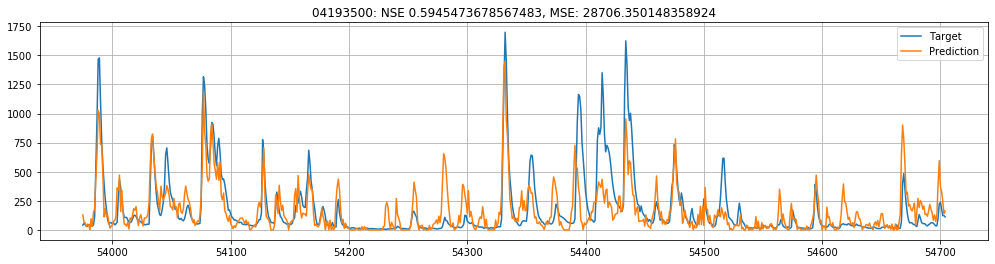

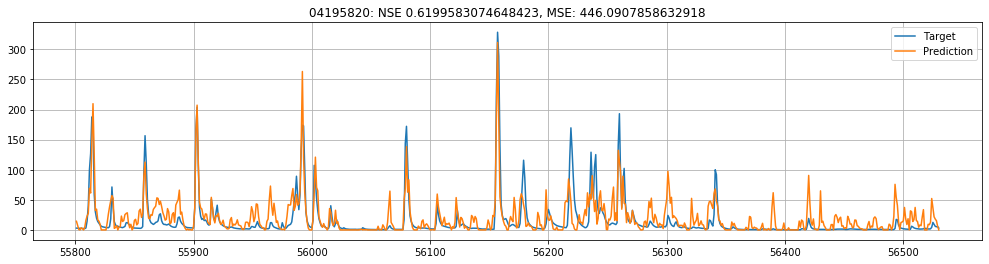

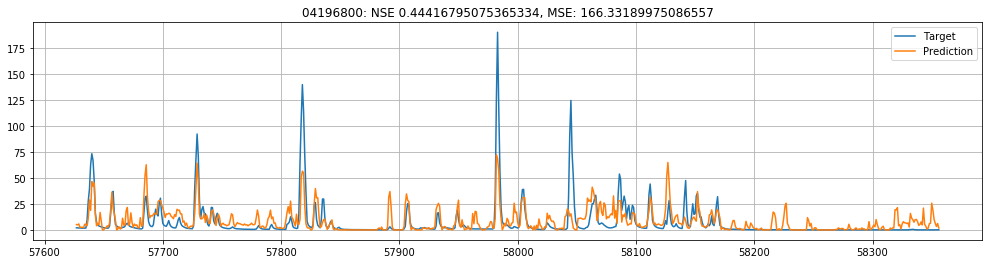

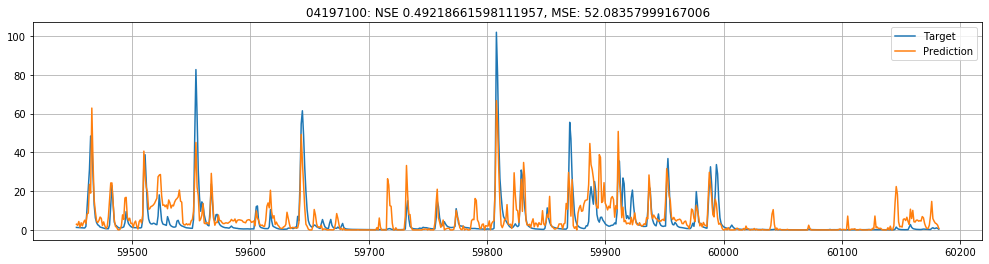

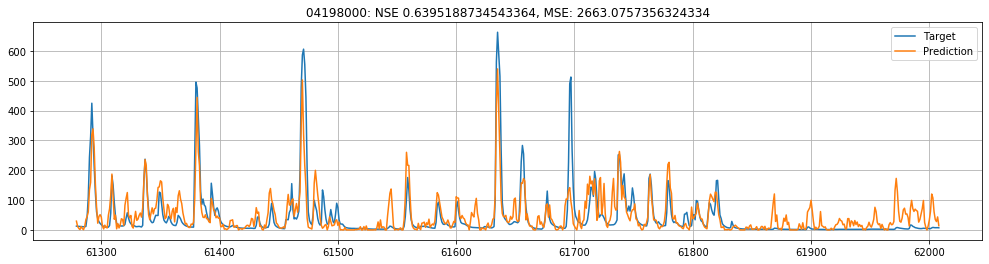

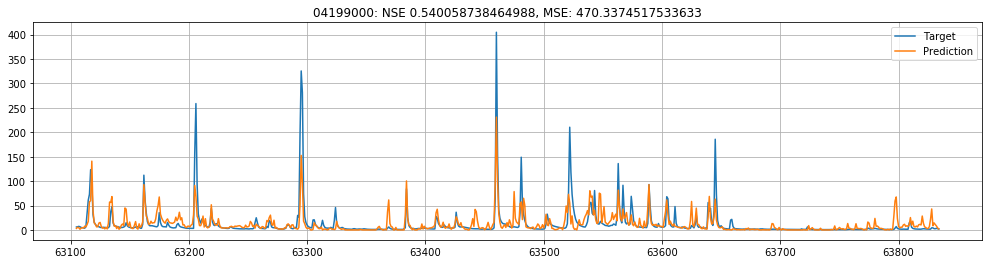

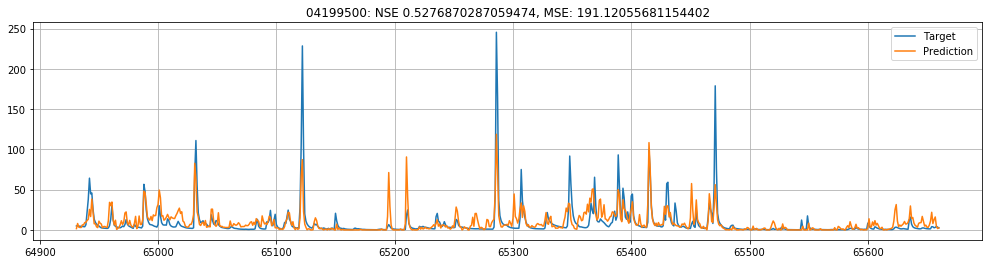

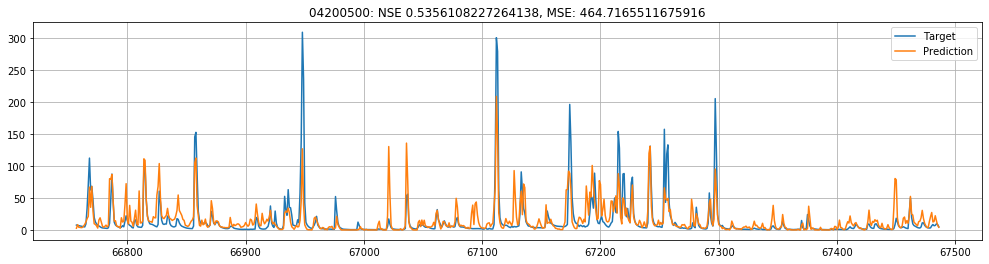

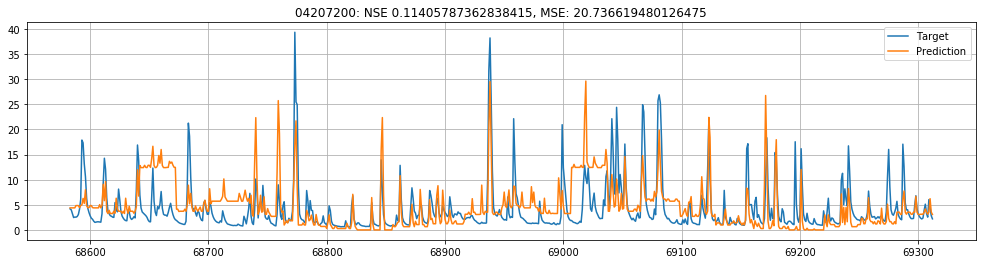

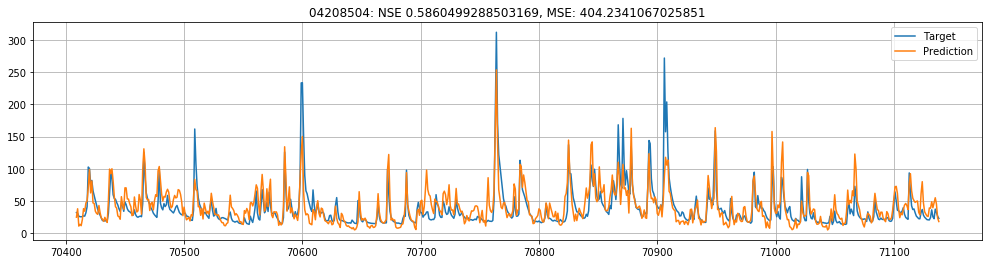

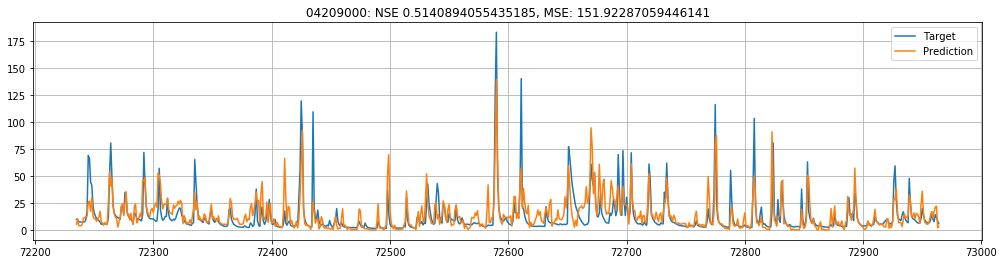

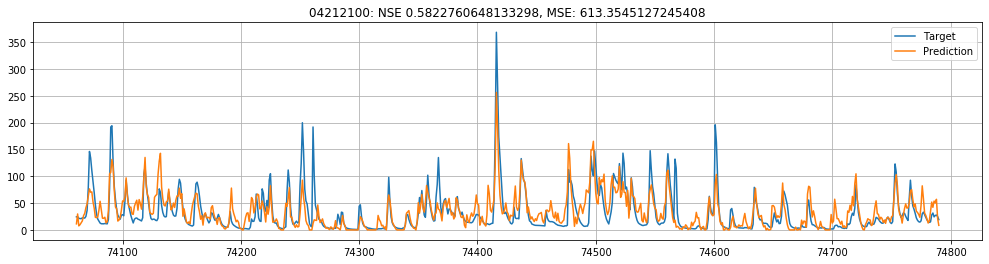

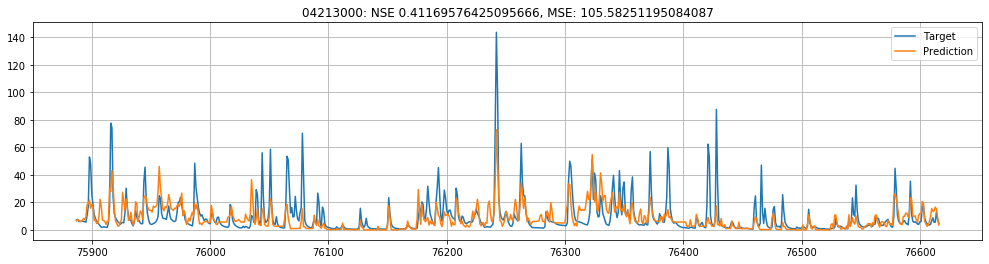

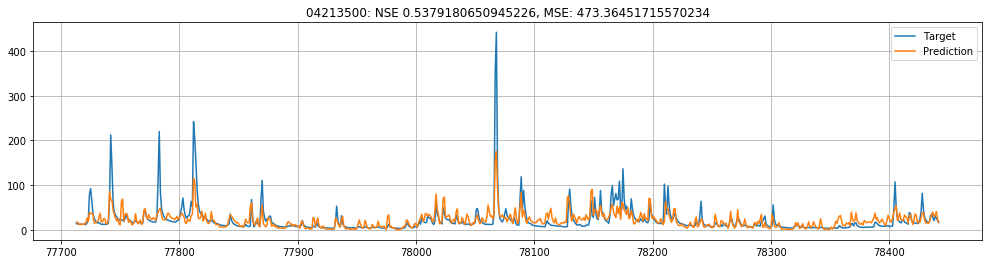

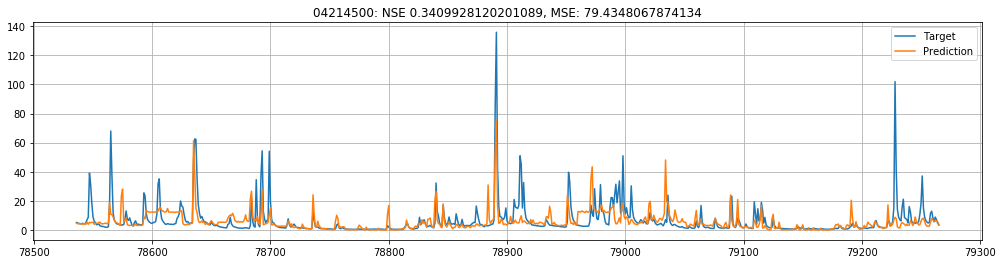

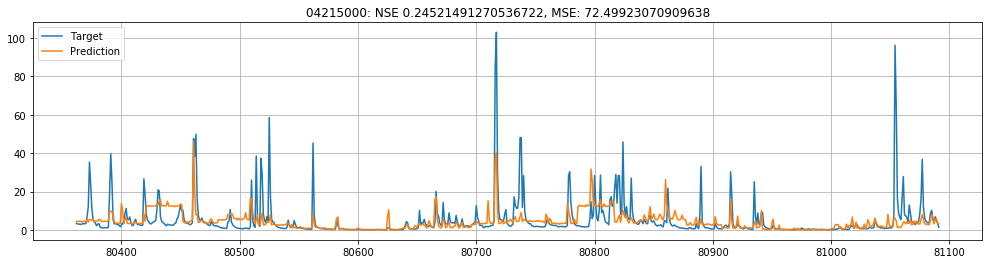

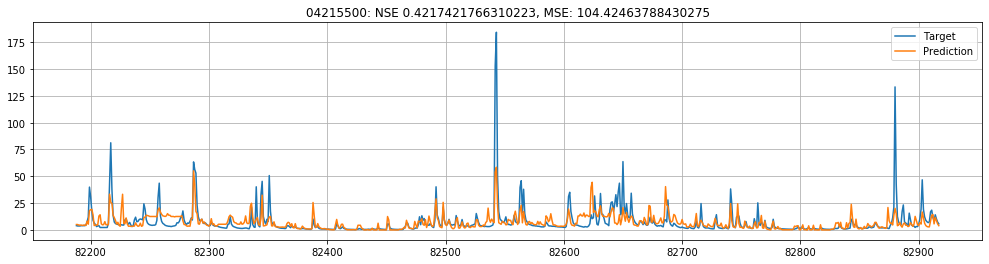

In [5]:
nse_list = []
mse_list = []
grouped_predict = predict.groupby('station')
for station in grouped_predict.groups.keys():
    station_predict = grouped_predict.get_group(station)
    nse, mse = evaluate.evaluate_daily(station, station_predict[['runoff']], station_predict['actual'], plot=True)
    nse_list.append(nse)
    mse_list.append(mse)
    
    print(station, '\tNSE:', nse, '\tMSE:', mse, '(clipped to 0)')

print('Median NSE (clipped to 0)', np.median(nse_list), '/ Min', np.min(nse_list), '/ Max', np.max(nse_list))
print('Median MSE (clipped to 0)', np.median(mse_list), '/ Min', np.min(mse_list), '/ Max', np.max(mse_list))

In [6]:
load_data.pickle_results('XGBoost_VIC_aggregateForcings_oneModel', predict[['date', 'station', 'runoff', 'actual']].rename({'runoff': 'prediction'}, axis=1).reset_index(drop=True), time_stamp)

'XGBoost_VIC_aggregateForcings_oneModel_20190708-203652.pkl'

In [7]:
load_data.pickle_model('XGBoost_VIC_aggregateForcings_oneModel', m, 'all', time_stamp, model_type='sklearn')

Saved model as ../pickle/models/XGBoost_VIC_aggregateForcings_oneModel_all_20190708-203652.pkl
